In [1]:
%matplotlib nbagg
%matplotlib inline
import MDAnalysis as mda
import MDAnalysis.analysis.leaflet
import matplotlib
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import nglview as nv
import copy
import warnings
warnings.filterwarnings('ignore')

# indicate the name of the simulation, the path of the data and the .gro and .xtc files to import
# no GM1

name = '_DPPC_DIPC_chol_352'

path = '/home/julie/analysis/bilayers/3-5-2/DPPC_DIPC_chol/'
fgro = 'run_DPPC_DIPC_CHOL_43nm_352_mb_fixed_t1_ref9999ns.gro'
fxtc = 'run_DPPC_DIPC_CHOL_43nm_352_mb_fixed_t1.xtc'

In [2]:
# indicate the name of the simulation, the path of the data and the .gro and .xtc files to import
# 5% GM1

name = '_DPPC_DIPC_chol_352_5GM1'

path = '/home/julie/analysis/bilayers/3-5-2/DPPC_DIPC_chol_GM1_5/'
pathd = '/home/julie/analysis/bilayers/3-5-2/DPPC_DIPC_chol_GM1_5/dynamics/'

fgro = 'run_DPPC_DIPC_CHOL_GM1_5_43nm_10ms_mb_fixed_t1_ref9999ns.gro'
fxtc = 'run_DPPC_DIPC_CHOL_GM1_5_43nm_10ms_mb_fixed_t1.xtc'

# indicate the name of the simulation, the path of the data and the .gro and .xtc files to import
# 10% GM1

name = '_DPPC_DIPC_chol_352_10GM1'

path = '/home/julie/analysis/bilayers/3-5-2/DPPC_DIPC_chol_GM1_10/'

fgro = 'run_DPPC_DIPC_CHOL_GM1_10_43nm_10ms_mb_fixed_t1_ref9999ns.gro'
fxtc = 'run_DPPC_DIPC_CHOL_GM1_10_43nm_10ms_mb_fixed_t1.xtc'

# indicate the name of the simulation, the path of the data and the .gro and .xtc files to import
# 20% GM1

name = '_DPPC_DIPC_chol_352_20GM1'

path = '/home/julie/analysis/bilayers/3-5-2/DPPC_DIPC_chol_GM1_20/'

fgro = 'run_DPPC_DIPC_CHOL_GM1_20_43nm_10ms_mb_fixed_t1_ref9999ns.gro'
fxtc = 'run_DPPC_DIPC_CHOL_GM1_20_43nm_10ms_mb_fixed_t1.xtc'

In [3]:
# load gro and xtc files
u = mda.Universe( path+fgro, path+fxtc)

In [4]:
sel_all = u.select_atoms("all and resname DPPC")

In [5]:
# visualize the bilayer and choose the frame to study

v= nv.show_mdanalysis(sel_all)
v.add_spacefill(sel_all, scale=2.0)
v

A Jupyter Widget

# boucle pour travailler sur des frames de la simu

tmes = 1000
for ts in u.trajectory:
     if (ts.frame%tmes == 0):
            print(ts.frame)
            xmin=0
            ymin=0
            str_sel= "(prop x> "+str(xmin)+" and prop y> "+str(ymin)+") and (name GL1 or name AM1)"
            patch = u.select_atoms(str_sel).positions
            
            Lo = u.select_atoms("(prop x> "+str(xmin)+" and prop y> "+str(ymin)+") and name PO4 and resname DPPC").positions
            Ld = u.select_atoms("(prop x> "+str(xmin)+" and prop y> "+str(ymin)+") and name PO4 and resname DIPC").positions
            GM1 = u.select_atoms("(prop x> "+str(xmin)+" and prop y> "+str(ymin)+") and name AM1").positions
            chol = u.select_atoms("(prop x> "+str(xmin)+" and prop y> "+str(ymin)+") and name ROH").positions

            xmax = max(patch[:,0])
            ymax = max(patch[:,1])
            
            xmin = min(patch[:,0])
            ymin = min(patch[:,1])
            
            N = 15
            dx = (xmax-xmin)/N
            dy = (ymax-ymin)/N
            plt.scatter(Lo[:,1]/N, -Lo[:,0]/N, marker='.', c='yellow', s=2)
            plt.scatter(Ld[:,1]/N, -Ld[:,0]/N, marker='.', c='b', s=2)
            plt.scatter(GM1[:,1]/N, -GM1[:,0]/N, marker='+', c='g', s=2)
            plt.savefig(path2+'t'+str(ts.frame)+'.pdf', format='pdf',bbox_inches='tight')
            #pour enregistrer les plots


In [6]:
# needed functions for the local curvature computation

def F_neigh(n) :
    neigh[0] = n
    i=n%N
    j=int(n/N)
    ip1=(i+1)%N
    im1=(i-1)%N
    jp1=(j+1)%N
    jm1=(j-1)%N
    neigh[1] = ip1+N*j
    neigh[2] = im1+N*j
    neigh[3] = i+N*jm1
    neigh[4] = i+N*jp1

def Lap(n) :
    lap = ( h[neigh[4]]+h[neigh[3]]-2*h[neigh[0]] ) / dx**2 + ( h[neigh[1]]+h[neigh[2]]-2*h[neigh[0]] ) / dy**2
    return(lap)


In [58]:
# boucle pour calculer la courbure au cours du temps
t = []

C_t_Lo = []
C_t_Ld = []
thick_t_Lo = []
thick_t_Ld = []

cov_phi_t = []
cov_e_t = []
cov_c_t = []
cov_c_GM1_Lo_t = []
cov_c_GM1_bound_Lo_t = []


tmes = 300
t_start = 5100
N = 15
threshold = 0.6 # composition threshold from which the box is considered Lo, below it is considered Ld
#threshold2 = 0.6 a voir pour la frontiere

for ts in u.trajectory:
     if (ts.frame%tmes == 0 and ts.frame>=t_start):
            
            print(ts.frame)
            t.append(ts.frame)
            
            xmin=0
            ymin=0
            str_sel= "(prop x> "+str(xmin)+" and prop y> "+str(ymin)+") and (name PO4 or name GM1)"
            patch = u.select_atoms(str_sel).positions
            
            xmax = max(patch[:,0])
            ymax = max(patch[:,1])
            
            xmin = min(patch[:,0])
            ymin = min(patch[:,1])
            
            
            dx = (xmax-xmin)/N
            dy = (ymax-ymin)/N
           
            Lf = mda.analysis.leaflet.LeafletFinder(u, 'name PO4 or name GM1')
            leaflet0 = Lf.groups(0)
            leaflet1 = Lf.groups(1)
            
            # leaflet 0 -----------------------------------------------------------------------------------------------------
            
            bary0 = []

            Mphi0_Lo = np.zeros((N,N)) # ratio DPPC / all PC in each box
            M_nb_GM1 = np.zeros((N,N)) # number of GM1 molecules in each box

            for i in range(0,N):
                xs = xmin + i*dx
                for j in range(0,N):
                    ys = ymin + j*dy

                    # barycenter of all molecules in each box
                    str_sel= "(prop x>= "+str(xs)+" and prop x< "+str(xs+dx)+" and prop y>= "+str(ys)+" and prop y< "+str(ys+dy)+")"
                    b0=leaflet0.select_atoms(str_sel).centroid().tolist()
                    bary0.append(b0)

                    # PC composition rates in each box
                    sel_totPC= "(prop x>= "+str(xs)+" and prop x< "+str(xs+dx)+" and prop y>= "+str(ys)+" and prop y< "+str(ys+dy)+" and name PO4)"
                    tot0PC= leaflet0.select_atoms(sel_totPC).positions
                    n_tot0PC=len(tot0PC) # total number of PC

                    sel_Lo= "(prop x>= "+str(xs)+" and prop x< "+str(xs+dx)+" and prop y>= "+str(ys)+" and prop y< "+str(ys+dy)+") and resname DPPC"
                    Lo0= leaflet0.select_atoms(sel_Lo).positions
                    n_Lo0=len(Lo0) # number of molecules of the Lo phase (DPPC here)
                    
                    if  n_tot0PC!=0:
                        
                        phi0_Lo=n_Lo0/n_tot0PC
                        Mphi0_Lo[i,j]=phi0_Lo
                    
                    # GM1 rates in each box        
                    sel_GM1= "(prop x>= "+str(xs)+" and prop x< "+str(xs+dx)+" and prop y>= "+str(ys)+" and prop y< "+str(ys+dy)+") and name GM1"
                    GM1_0= leaflet0.select_atoms(sel_GM1).positions
                    n_GM1_0=len(GM1_0) # number of GM1 molecules        

                    M_nb_GM1[i,j]=n_GM1_0


            bary0=np.array(bary0)
            
            # leaflet 1 -----------------------------------------------------------------------------------------------------
            
            bary1 = []

            Mphi1_Lo = np.zeros((N,N))

            for i in range(0,N):
                xs = xmin + i*dx
                for j in range(0,N):
                    ys = ymin + j*dy

                    # barycenter of all molecules in each box
                    str_sel= "(prop x>= "+str(xs)+" and prop x< "+str(xs+dx)+" and prop y>= "+str(ys)+" and prop y< "+str(ys+dy)+")"
                    b1=leaflet1.select_atoms(str_sel).centroid().tolist()
                    bary1.append(b1)

                    # composition rates in each box
                    sel_totPC= "(prop x>= "+str(xs)+" and prop x< "+str(xs+dx)+" and prop y>= "+str(ys)+" and prop y< "+str(ys+dy)+" and name PO4)"
                    tot1PC= leaflet1.select_atoms(sel_totPC).positions
                    n_tot1PC=len(tot1PC) # total number of PC

                    sel_Lo= "(prop x>= "+str(xs)+" and prop x< "+str(xs+dx)+" and prop y>= "+str(ys)+" and prop y< "+str(ys+dy)+") and resname DPPC"
                    Lo1= leaflet1.select_atoms(sel_Lo).positions
                    n_Lo1=len(Lo1) # number of molecules of the Lo phase (DPPC here)

                    if  n_tot1PC!=0:
                        
                        phi1_Lo=n_Lo1/n_tot1PC
                        Mphi1_Lo[i,j]=phi1_Lo


            bary1=np.array(bary1)
            #--------------------------------------------------------------------------------------------------------------------------------
            # mean (between the 2 leaflets) composition field
            
            Mphi_mean = (Mphi0_Lo+Mphi1_Lo)/2

##################################################################################################################################  
            # compute the local thickness
    
            bary0.shape=(N,N,3)
            bary1.shape=(N,N,3)

            diffz=bary0[:,:,2]-bary1[:,:,2]

            bary0.shape=(N*N,3)
            bary1.shape=(N*N,3)
            
##################################################################################################################################  
            # compute the local curvature
            
            neigh = [0,0,0,0,0]
            h=bary1[:,2]
            laplacian = []
            
            for i in range(N*N) :
                F_neigh(i)
                laplacian.append(Lap(i))
                
            curv = copy.copy(bary0)
            curv[:,2] = laplacian
            C = curv[:,2]
            C.shape=(N,N)

##################################################################################################################################  
            # upper leaflet binary composition and local thickness and curvature associated to Lo phase
            
            Mphi0_bin = np.zeros((N,N))

            for i in range(N):
                for j in range(N):
                    if Mphi0_Lo[i,j]>= threshold :
                        Mphi0_bin[i,j]=1
                        
            # if the phase of the box is Lo then the thickness is averaged
            thick_Lo = []
            thick_Ld = []
            for i in range(N):
                for j in range(N):
                    if Mphi0_bin[i,j] == 1 :
                        thick_Lo.append(diffz[i,j])
                    else:
                        thick_Ld.append(diffz[i,j])
                        
            thick_t_Lo.append(np.mean(thick_Lo))
            thick_t_Ld.append(np.mean(thick_Ld))
            
            # if the phase of the box is Lo then the curvature is averaged
            C_Lo = []
            C_Ld = []
            for i in range(N):
                for j in range(N):
                    if Mphi0_bin[i,j] == 1 :
                        C_Lo.append(C[i,j])
                    else:
                        C_Ld.append(C[i,j])
                        
            C_t_Lo.append(np.mean(C_Lo))
            C_t_Ld.append(np.mean(C_Ld))
##################################################################################################################################  
            # Lo boundary determination
            Mphi0_bin.shape=(N*N)
            M_bound_Lo = np.zeros((N*N))
            neigh = [0,0,0,0,0]
            for i in range(N*N) :
                F_neigh(i)
                if Mphi0_bin[i]==1 and (Mphi0_bin[i]!=Mphi0_bin[neigh[1]] or Mphi0_bin[i]!=Mphi0_bin[neigh[2]] or Mphi0_bin[i]!=Mphi0_bin[neigh[3]] or Mphi0_bin[i]!=Mphi0_bin[neigh[4]]):
                    M_bound_Lo[i]=1
            M_bound_Lo.shape=(N,N)
            Mphi0_bin.shape=(N,N)
            
##################################################################################################################################  
            # GM1 repartition
            nb_GM1_tot = np.sum(M_nb_GM1)
            
            # in the Lo phase
            M_GM1_Lo = Mphi0_bin*M_nb_GM1
            nb_GM1_Lo = np.sum(M_GM1_Lo)
            rate_GM1_Lo = nb_GM1_Lo/nb_GM1_tot
            
            # at the Lo boundary
            M_GM1_bound_Lo = M_bound_Lo*M_nb_GM1
            nb_GM1_bound_Lo = np.sum(M_GM1_bound_Lo)
            rate_GM1_bound_Lo = nb_GM1_bound_Lo/nb_GM1_tot
    
##################################################################################################################################  
            # compute the correlations (covariance) 
            
            # composition of the 2 leaflets
            sum = 0
            for i in range(0,N):
                for j in range(0,N):
                    sum = sum + ( Mphi0_Lo[i,j]*Mphi1_Lo[i,j] - np.mean(Mphi0_Lo)*np.mean(Mphi1_Lo) ) / np.std(Mphi0_Lo)/np.std(Mphi1_Lo)
            cov_phi = sum/N**2
            print(cov_phi)
            cov_phi_t.append(cov_phi)
    
            # composition and local thickness           
            sum = 0
            for i in range(0,N):
                for j in range(0,N):
                    sum = sum + ( Mphi_mean[i,j]*diffz[i,j] - np.mean(Mphi_mean)*np.mean(diffz) ) / np.std(Mphi_mean)/np.std(diffz)
            cov_e = sum/N**2
            print(cov_e)
            cov_e_t.append(cov_e)
            
            # composition and local curvature
            sum = 0
            for i in range(0,N):
                for j in range(0,N):
                    sum = sum + ( C[i,j]*Mphi0_Lo[i,j] - np.mean(C)*np.mean(Mphi0_Lo) ) / np.std(C)/np.std(Mphi0_Lo)
            cov_c = sum/N**2
            print(cov_c) 
            cov_c_t.append(cov_c)
            
            # GM1 in Lo phase and local curvature
            sum = 0
            for i in range(0,N):
                for j in range(0,N):
                    sum = sum + ( C[i,j]*M_GM1_Lo[i,j] - np.mean(C)*np.mean(M_GM1_Lo) ) / np.std(C)/np.std(M_GM1_Lo)
            cov_c_GM1_Lo = sum/N**2
            print(cov_c_GM1_Lo)
            cov_c_GM1_Lo_t.append(cov_c_GM1_Lo)
            
            # GM1 at the Lo phase boundary and local curvature
            sum = 0
            for i in range(0,N):
                for j in range(0,N):
                    sum = sum + ( C[i,j]*M_GM1_bound_Lo[i,j] - np.mean(C)*np.mean(M_GM1_bound_Lo) ) / np.std(C)/np.std(M_GM1_bound_Lo)
            cov_c_GM1_bound_Lo = sum/N**2
            print(cov_c_GM1_bound_Lo)
            cov_c_GM1_bound_Lo_t.append(cov_c_GM1_bound_Lo)
            
            # a voir GM1 et Ld et surface ratio
                       
##################################################################################################################################  
            # plot                        
            s = 10
            plt.subplot(221)
            plt.imshow(Mphi_mean, interpolation='gaussian')
            plt.colorbar()
            plt.title('Composition', fontsize=s)
            plt.subplot(222)
            plt.imshow(diffz, interpolation='gaussian')
            plt.colorbar()
            plt.title('Local thickness ($\AA$)', fontsize=s)
            plt.subplot(223)
            plt.imshow(Mphi0_bin)
            plt.colorbar()
            plt.title('Upper leaflet binary composition', fontsize=s)
            plt.subplot(224)
            plt.imshow(-C, interpolation='gaussian')
            plt.colorbar()
            plt.title('Upper leaflet local curvature ($\AA^{-1}$)', fontsize=s)
            plt.subplots_adjust(bottom=0.1, right=0.9, top=0.9, hspace = 0.5)
            plt.savefig(pathd+'compo-thick_Lo_curv'+name+'_t'+str(ts.frame)+'.pdf', format='pdf',bbox_inches='tight')
            plt.clf()

5100
0.7893345273276859
0.8856866127015112
-0.10484060459848593
-0.22028298147591316
-0.13229959368721014
5400
0.8235432167657085
0.8928632056386882
-0.10661614350288796
-0.1701873327231141
-0.14839948795555363
5700
0.7815303628954813
0.8682961191938724
-0.04849850137788574
-0.12150597781740158
-0.11330664423503588
6000
0.7797483670548894
0.8819820091433972
-0.15328320514085517
-0.22739627298560697
-0.13159032478209257
6300
0.801261162079
0.8660982404814211
-0.12938179625900656
-0.23938848973022825
-0.17348634664263313
6600
0.8283756486991413
0.8618144727034364
-0.12836553826342664
-0.21629262863976098
-0.1751644144463173
6900
0.890232029916825
0.8998483175517031
-0.15604519511233408
-0.21451701415197047
-0.19806889879410397
7200
0.8746657761077672
0.897178279587167
-0.20634282470061843
-0.2716701012454555
-0.22434309430887203
7500
0.8518239701614922
0.8799290198499226
-0.11048627268880162
-0.18554380853574967
-0.1636744630590181
7800
0.8809752808344788
0.9167034213668378
-0.0433538419

<Figure size 432x288 with 0 Axes>

In [36]:
xprint = t_start+(max(t)-t_start)/2

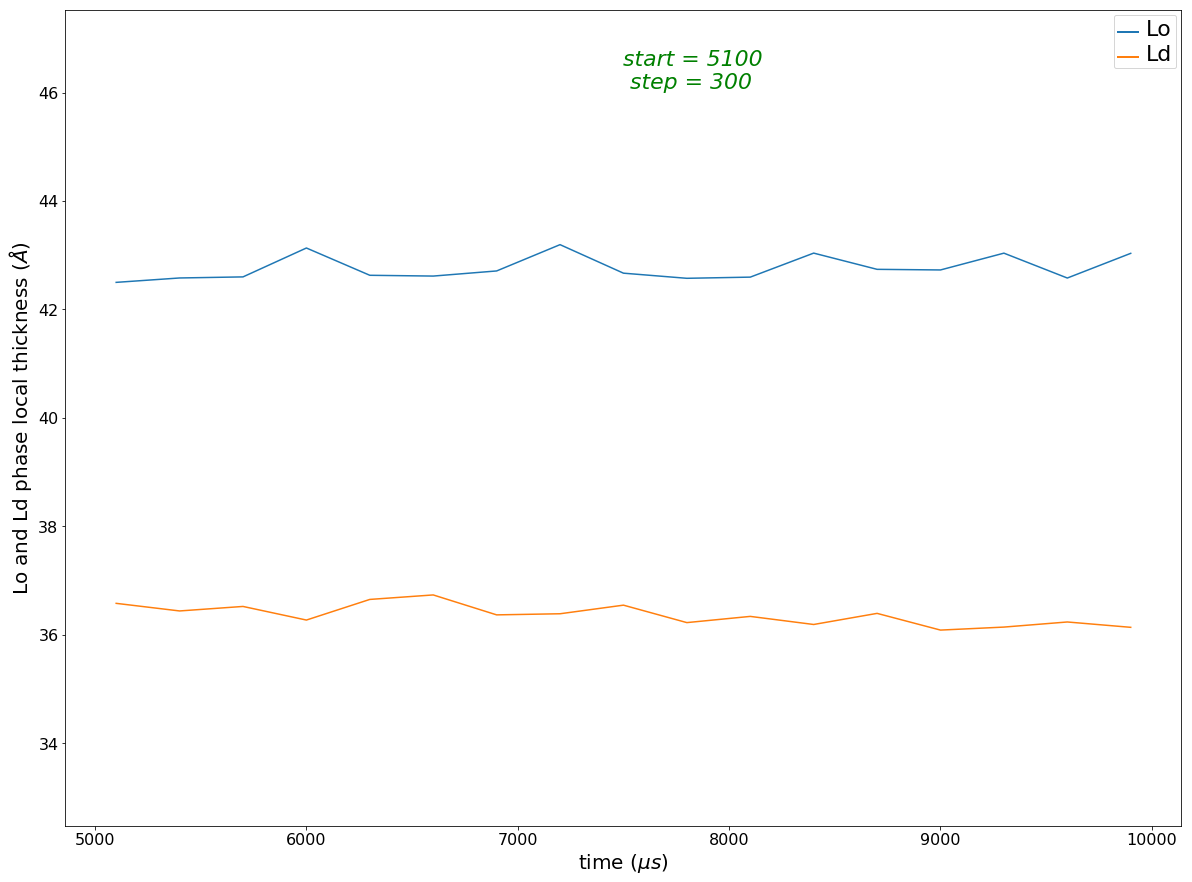

In [38]:
fig, ax = plt.subplots(figsize=(20, 15))

ax.plot(t, thick_t_Lo, label = 'Lo')
ax.plot(t, thick_t_Ld, label = 'Ld')

ytop = max(max(thick_t_Lo, thick_t_Ld)) + max(max(thick_t_Lo, thick_t_Ld))/10
ymin = min(min(thick_t_Lo, thick_t_Ld)) - min(min(thick_t_Lo, thick_t_Ld))/10
yprint = max(max(thick_t_Lo, thick_t_Ld)) + max(max(thick_t_Lo, thick_t_Ld))/15

plt.xlabel('time ($\mu s$)',fontsize=20)
plt.xticks(fontsize=16)
plt.ylabel('Lo and Ld phase local thickness ($\AA$)',fontsize=20)
plt.yticks(fontsize=16)
plt.annotate('start = %.0lf\n step = %.0lf' % (t_start, tmes), color='g', fontsize=22, style='italic', xy=(xprint,yprint), xytext=(xprint,yprint))

legend = ax.legend(loc='upper right', bbox_to_anchor=(1, 1))
# The frame is matplotlib.patches.Rectangle instance surrounding the legend.
frame = legend.get_frame()
#frame.set_facecolor('0.90')
# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize(22)
for label in legend.get_lines():
    label.set_linewidth(2)  # the legend line width

plt.ylim(ymin,ytop)
#plt.grid(True)

plt.savefig(pathd+'thickness_time'+name+'.pdf', format='pdf',bbox_inches='tight')

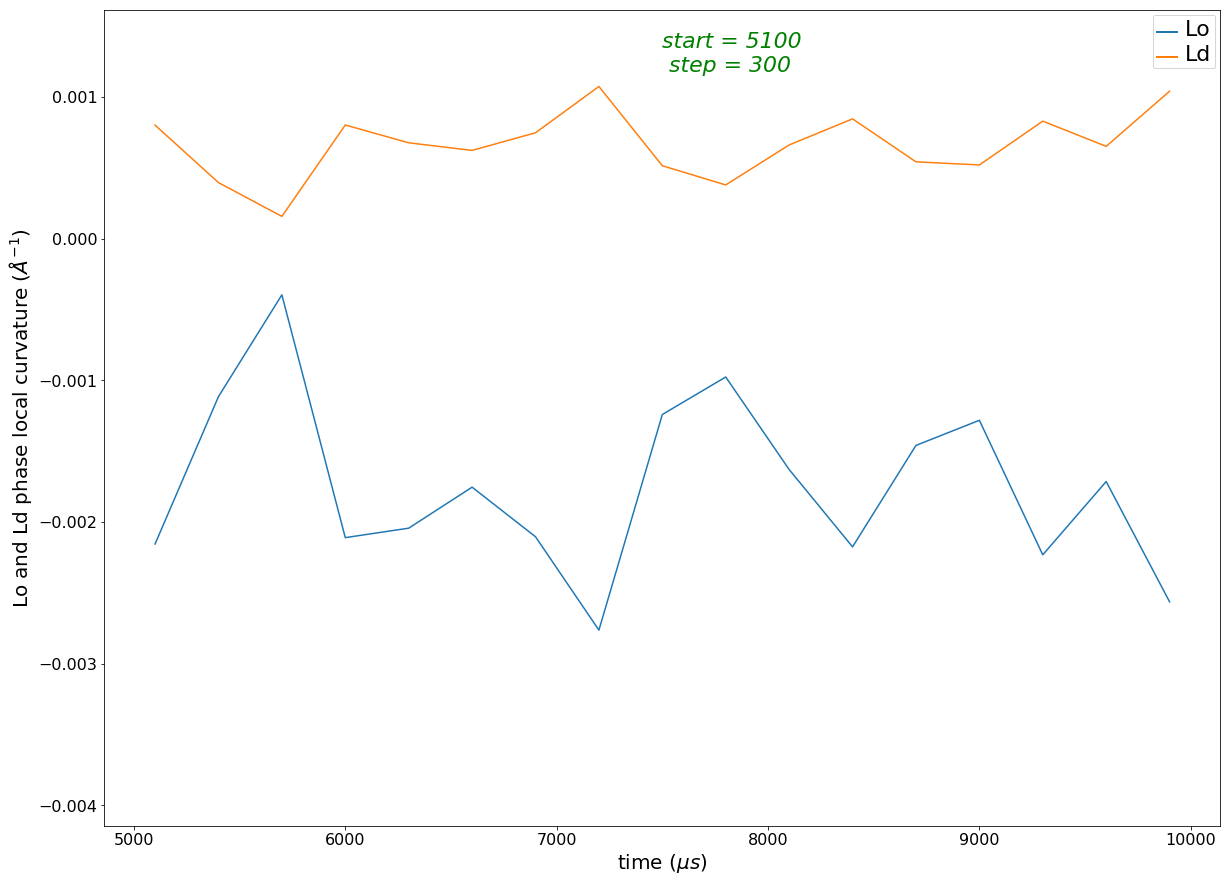

In [50]:
fig, ax = plt.subplots(figsize=(20, 15))

ax.plot(t, C_t_Lo, label = 'Lo')
ax.plot(t, C_t_Ld, label = 'Ld')

ytop = max(max(C_t_Lo, C_t_Ld)) + max(max(C_t_Lo, C_t_Ld))/2
ymin = min(min(C_t_Lo, C_t_Ld)) + min(min(C_t_Lo, C_t_Ld))/2
yprint = max(max(C_t_Lo, C_t_Ld)) + max(max(C_t_Lo, C_t_Ld))/10

plt.xlabel('time ($\mu s$)',fontsize=20)
plt.xticks(fontsize=16)
plt.ylabel('Lo and Ld phase local curvature ($\AA^{-1}$)',fontsize=20)
plt.yticks(fontsize=16)
plt.annotate('start = %.0lf\n step = %.0lf' % (t_start, tmes), color='g', fontsize=22, style='italic', xy=(xprint,yprint), xytext=(xprint,yprint))

legend = ax.legend(loc='upper right', bbox_to_anchor=(1, 1))
# The frame is matplotlib.patches.Rectangle instance surrounding the legend.
frame = legend.get_frame()
#frame.set_facecolor('0.90')
# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize(22)
for label in legend.get_lines():
    label.set_linewidth(2)  # the legend line width

plt.ylim(ymin,ytop)
#plt.grid(True)

plt.savefig(pathd+'curvature_time'+name+'.pdf', format='pdf',bbox_inches='tight')

In [51]:
xprint = max(t)-max(t)/10

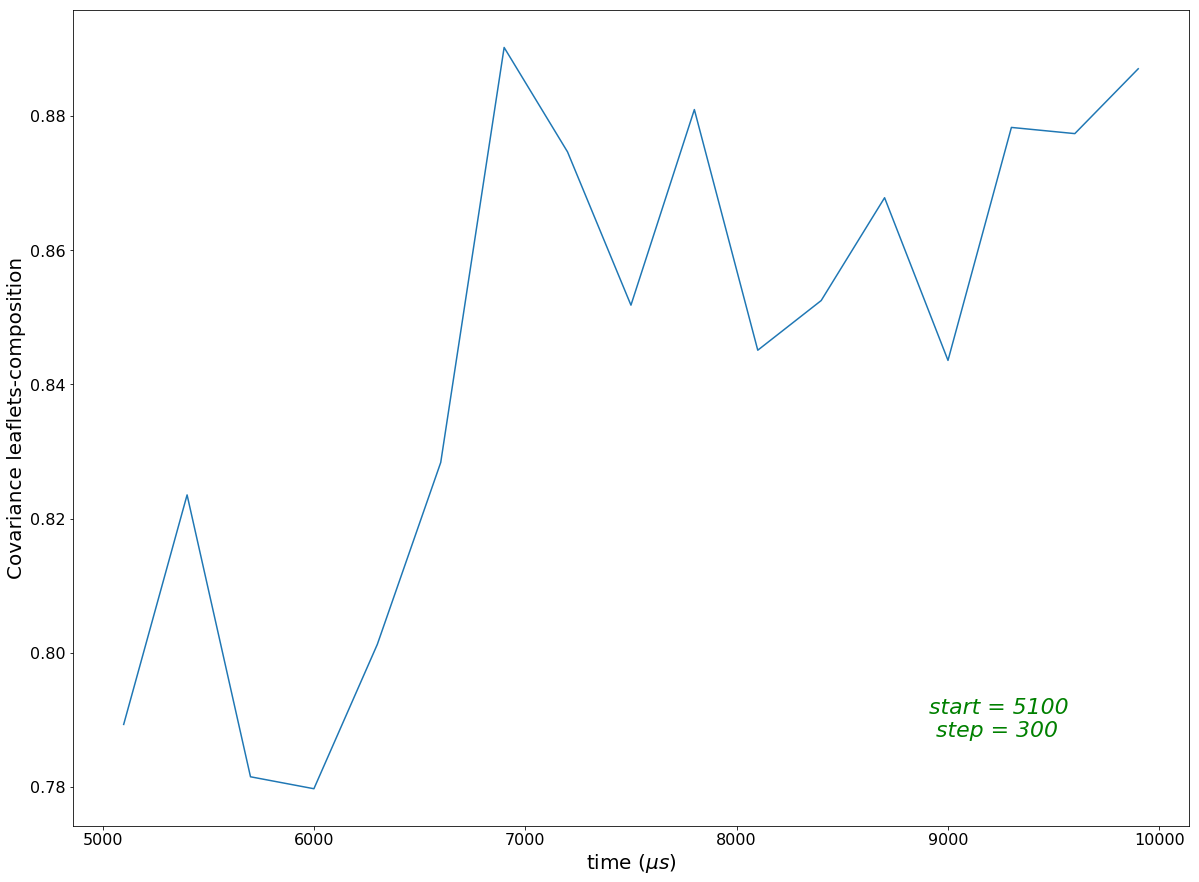

In [53]:
fig, ax = plt.subplots(figsize=(20, 15))

ax.plot(t, cov_phi_t)

yprint = min(cov_phi_t)+ min(cov_phi_t)/100

plt.xlabel('time ($\mu s$)',fontsize=20)
plt.xticks(fontsize=16)
plt.ylabel('Covariance leaflets-composition',fontsize=20)
plt.yticks(fontsize=16)
plt.annotate('start = %.0lf\n step = %.0lf' % (t_start, tmes), color='g', fontsize=22, style='italic', xy=(xprint,yprint), xytext=(xprint,yprint))

plt.savefig(pathd+'cov_phi_time'+name+'.pdf', format='pdf',bbox_inches='tight')

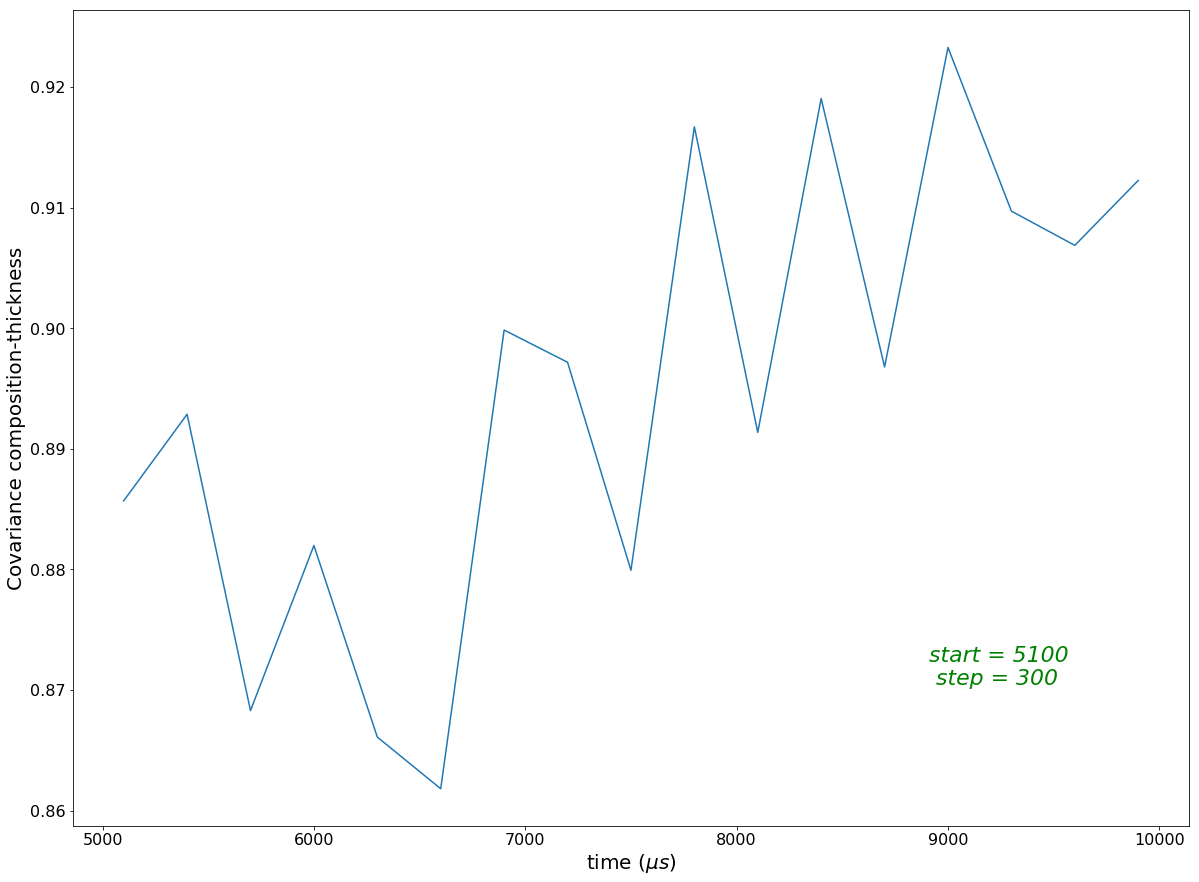

In [54]:
fig, ax = plt.subplots(figsize=(20, 15))

ax.plot(t, cov_e_t)

yprint = min(cov_e_t)+ min(cov_e_t)/100

plt.xlabel('time ($\mu s$)',fontsize=20)
plt.xticks(fontsize=16)
plt.ylabel('Covariance composition-thickness',fontsize=20)
plt.yticks(fontsize=16)
plt.annotate('start = %.0lf\n step = %.0lf' % (t_start, tmes), color='g', fontsize=22, style='italic', xy=(xprint,yprint), xytext=(xprint,yprint))

plt.savefig(pathd+'cov_e_time'+name+'.pdf', format='pdf',bbox_inches='tight')

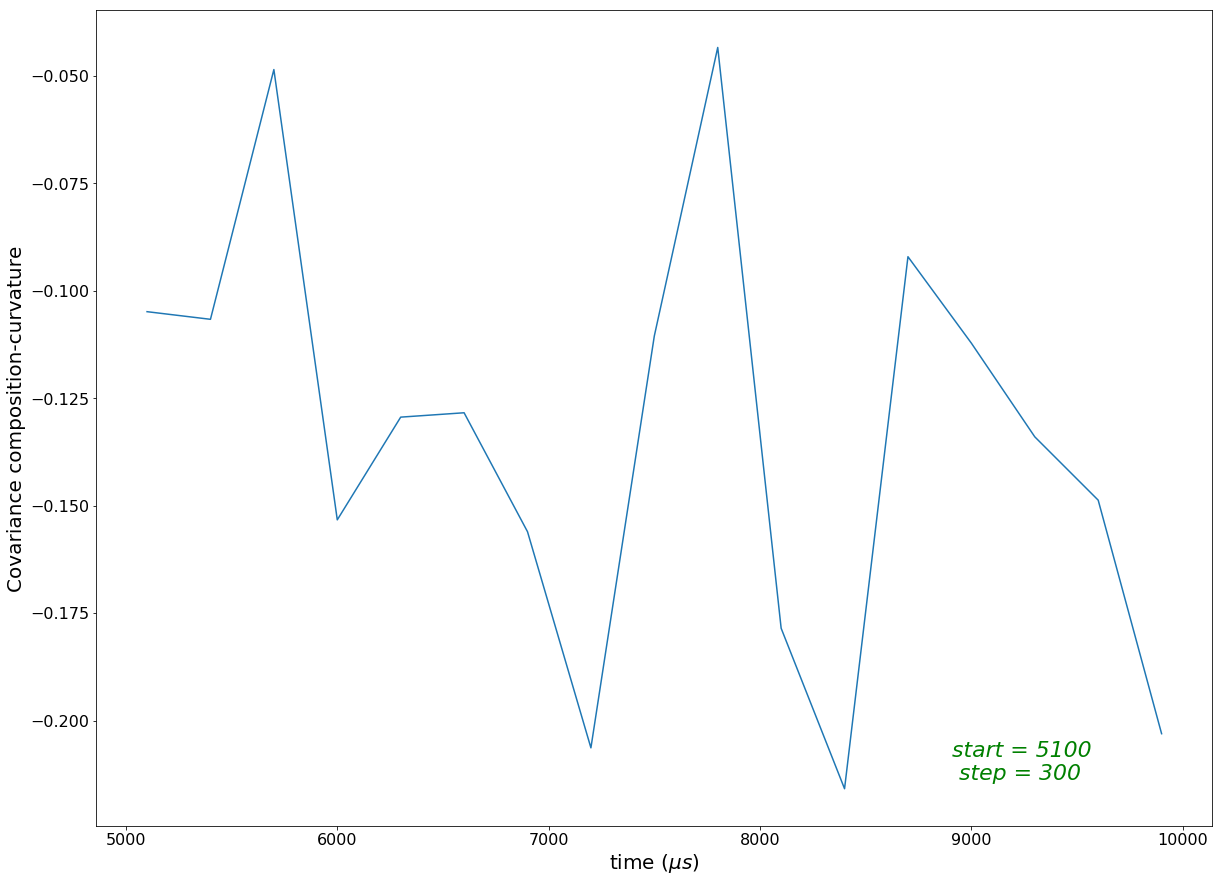

In [56]:
fig, ax = plt.subplots(figsize=(20, 15))

ax.plot(t, cov_c_t)

yprint = min(cov_c_t)-min(cov_c_t)/100

plt.xlabel('time ($\mu s$)',fontsize=20)
plt.xticks(fontsize=16)
plt.ylabel('Covariance composition-curvature',fontsize=20)
plt.yticks(fontsize=16)
plt.annotate('start = %.0lf\n step = %.0lf' % (t_start, tmes), color='g', fontsize=22, style='italic', xy=(xprint,yprint), xytext=(xprint,yprint))

plt.savefig(pathd+'cov_c_time'+name+'.pdf', format='pdf',bbox_inches='tight')

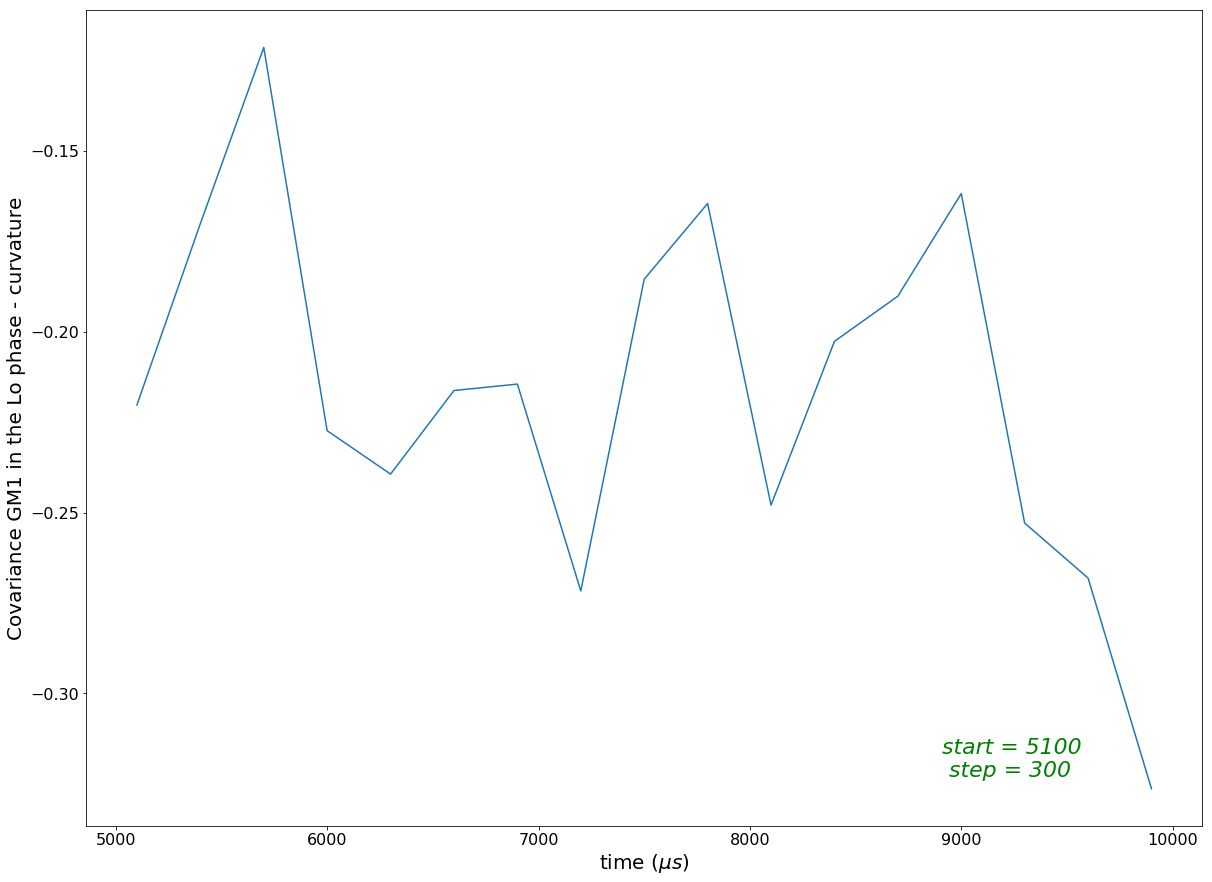

In [60]:
fig, ax = plt.subplots(figsize=(20, 15))

ax.plot(t, cov_c_GM1_Lo_t)

yprint = min(cov_c_GM1_Lo_t)-min(cov_c_GM1_Lo_t)/100

plt.xlabel('time ($\mu s$)',fontsize=20)
plt.xticks(fontsize=16)
plt.ylabel('Covariance GM1 in the Lo phase - curvature',fontsize=20)
plt.yticks(fontsize=16)
plt.annotate('start = %.0lf\n step = %.0lf' % (t_start, tmes), color='g', fontsize=22, style='italic', xy=(xprint,yprint), xytext=(xprint,yprint))

plt.savefig(pathd+'cov_c_GM1_Lo_time'+name+'.pdf', format='pdf',bbox_inches='tight')

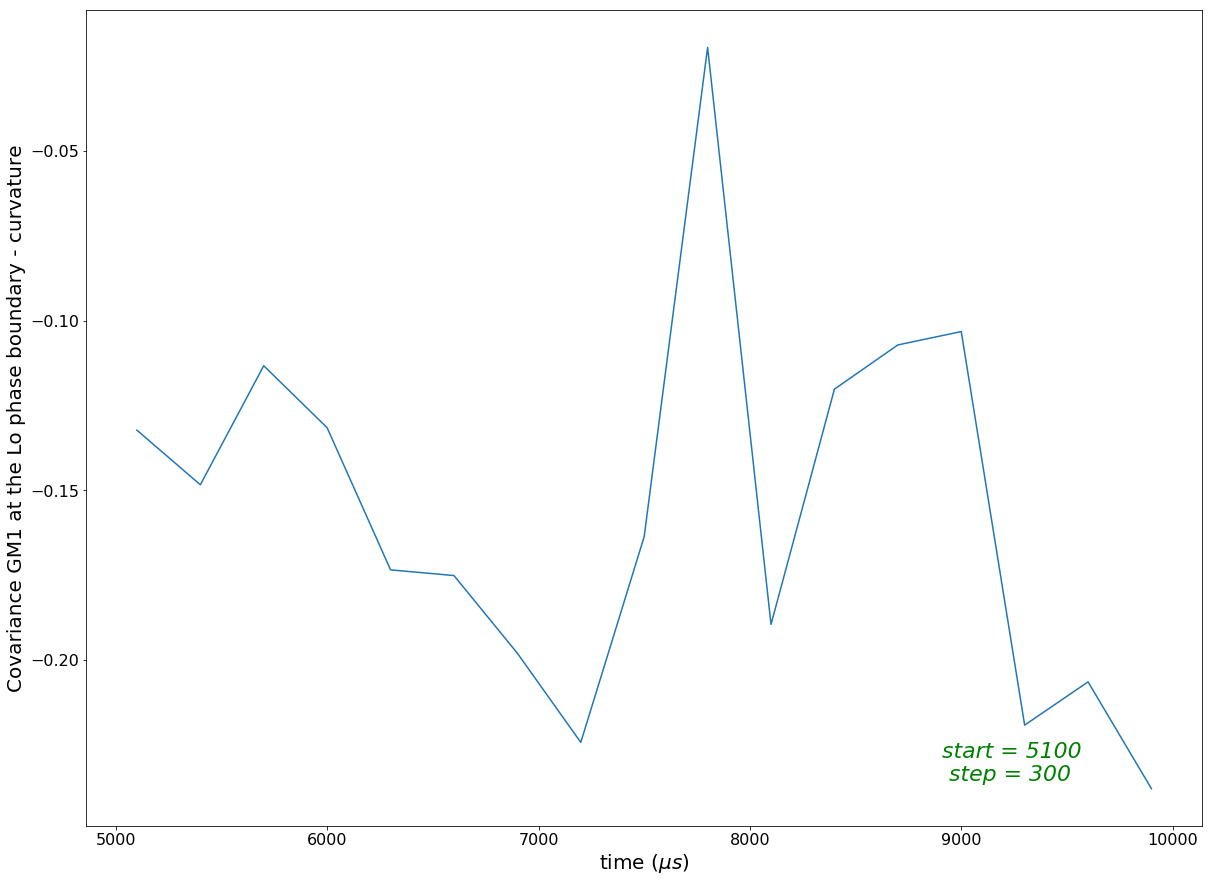

In [59]:
fig, ax = plt.subplots(figsize=(20, 15))

ax.plot(t, cov_c_GM1_bound_Lo_t)

yprint = min(cov_c_GM1_bound_Lo_t)-min(cov_c_GM1_bound_Lo_t)/100

plt.xlabel('time ($\mu s$)',fontsize=20)
plt.xticks(fontsize=16)
plt.ylabel('Covariance GM1 at the Lo phase boundary - curvature',fontsize=20)
plt.yticks(fontsize=16)
plt.annotate('start = %.0lf\n step = %.0lf' % (t_start, tmes), color='g', fontsize=22, style='italic', xy=(xprint,yprint), xytext=(xprint,yprint))

plt.savefig(pathd+'cov_c_GM1_bound_Lo_time'+name+'.pdf', format='pdf',bbox_inches='tight')